# Task 2: Hyperelasticity



In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib

# %% Own modules
import models as lm
importlib.reload(lm)

<module 'models' from 'f:\\CPShub\\Tutorial\\Task2_Group Xin and Huasen\\train\\models.py'>

### Data import

In [2]:
import numpy as np


data_biaxial = np.loadtxt('../calibration/biaxial.txt')
data_pure_shear = np.loadtxt('../calibration/pure_shear.txt')
data_uniaxial = np.loadtxt('../calibration/uniaxial.txt')


def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    W = data[:, 18] 
    return F, P, W

# 分别处理三种加载路径的数据
F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_pure_shear, P_pure_shear, W_pure_shear = process_data(data_pure_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

# 检查数据
print("Biaxial F:", F_biaxial.shape)
print("Biaxial P:", P_biaxial.shape)
print("Biaxial W:", W_biaxial.shape)

print("Pure Shear F:", F_pure_shear.shape)
print("Pure Shear P:", P_pure_shear.shape)
print("Pure Shear W:", W_pure_shear.shape)

print("Uniaxial F:", F_uniaxial.shape)
print("Uniaxial P:", P_uniaxial.shape)
print("Uniaxial W:", W_uniaxial.shape)


Biaxial F: (199, 3, 3)
Biaxial P: (199, 3, 3)
Biaxial W: (199,)
Pure Shear F: (250, 3, 3)
Pure Shear P: (250, 3, 3)
Pure Shear W: (250,)
Uniaxial F: (199, 3, 3)
Uniaxial P: (199, 3, 3)
Uniaxial W: (199,)


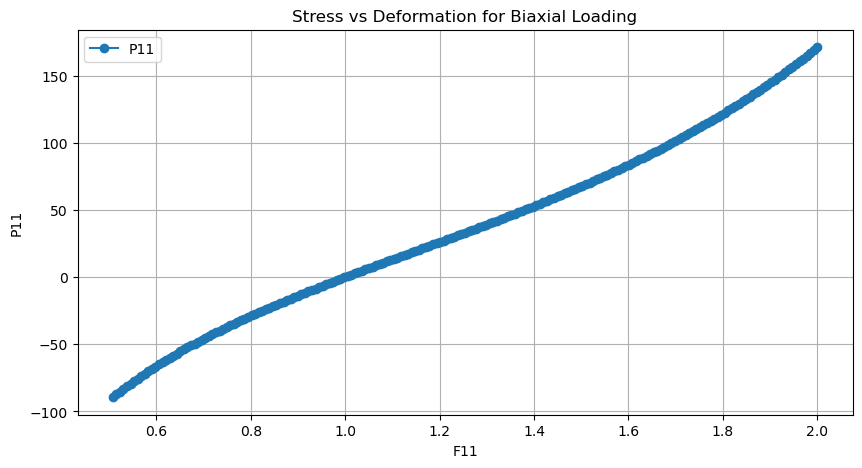

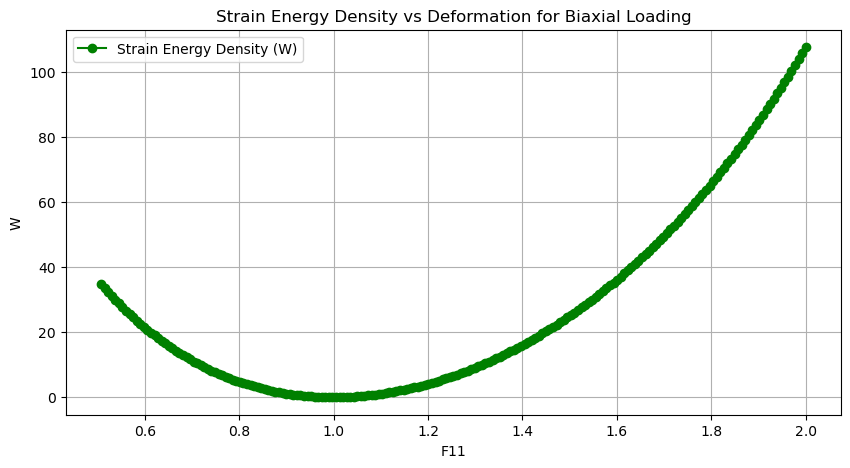

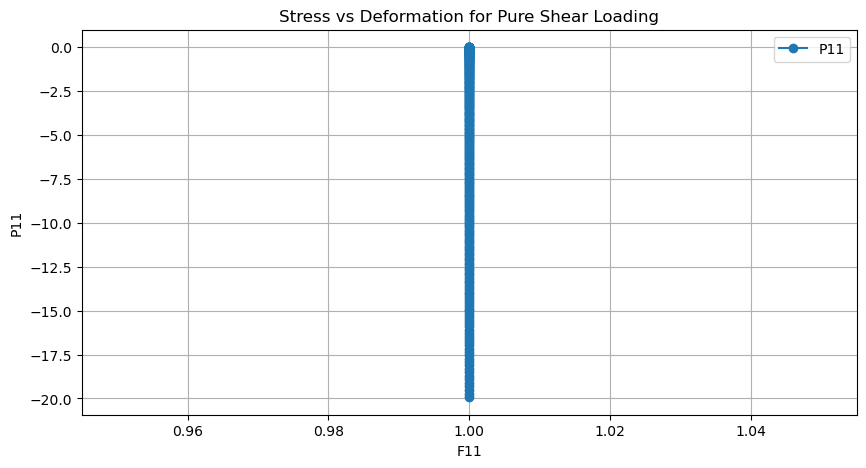

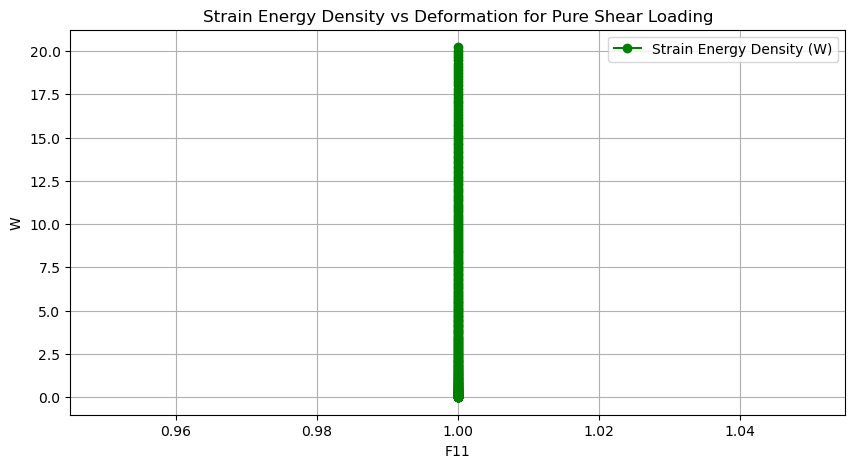

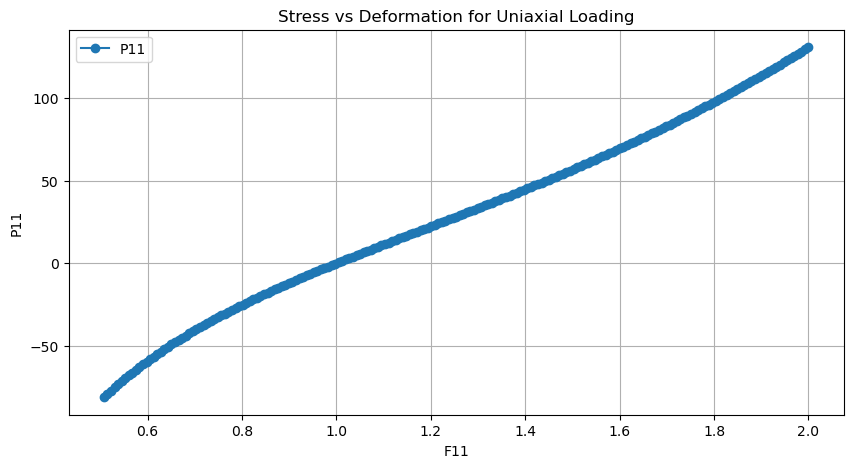

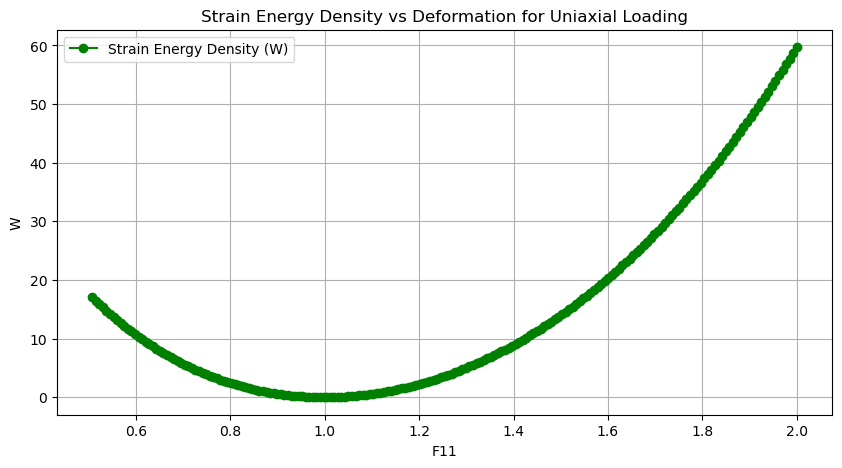

In [3]:
import matplotlib.pyplot as plt

# 可视化函数
def plot_stress_vs_deformation(F, P, W, title):
    # 假设我们主要关注 F11 和 P11 的关系
    F11 = F[:, 0, 0]  # 提取 F11 分量
    P11 = P[:, 0, 0]  # 提取 P11 分量

    # 绘制 P11 与 F11 的关系
    plt.figure(figsize=(10, 5))
    plt.plot(F11, P11, label="P11", marker="o", linestyle="-")
    plt.xlabel("F11")
    plt.ylabel("P11")
    plt.title(f"Stress vs Deformation for {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制 W 与 F11 的关系
    plt.figure(figsize=(10, 5))
    plt.plot(F11, W, label="Strain Energy Density (W)", marker="o", linestyle="-", color="green")
    plt.xlabel("F11")
    plt.ylabel("W")
    plt.title(f"Strain Energy Density vs Deformation for {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

# 分别绘制不同加载路径的结果
plot_stress_vs_deformation(F_biaxial, P_biaxial, W_biaxial, title="Biaxial Loading")
plot_stress_vs_deformation(F_pure_shear, P_pure_shear, W_pure_shear, title="Pure Shear Loading")
plot_stress_vs_deformation(F_uniaxial, P_uniaxial, W_uniaxial, title="Uniaxial Loading")


In [4]:
import numpy as np

def compute_invariants(F):
    # F shape is (batch_size, 3, 3)
    batch_size = F.shape[0]
    
    # 计算右 Cauchy-Green 张量 C = F^T * F
    # Using einsum for batch matrix multiplication
    C = np.einsum('bij,bjk->bik', F.transpose(0, 2, 1), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = np.trace(C, axis1=1, axis2=2)  # shape: (batch_size,)
    
    # For I2, compute trace(C@C) with batch operation
    C_square = np.einsum('bij,bjk->bik', C, C)
    I2 = 0.5 * (I1**2 - np.trace(C_square, axis1=1, axis2=2))  # shape: (batch_size,)
    
    # Compute determinant for each matrix in the batch
    J = np.linalg.det(F)  # shape: (batch_size,)
    
    # 定义结构张量 Gti
    Gti = np.array([
        [4, 0, 0],
        [0, 0.5, 0],
        [0, 0, 0.5]
    ])
    
    # 扩展 Gti 到批量维度
    Gti = np.tile(Gti[None, :, :], (batch_size, 1, 1))
    
    # 计算不变量 I4
    I4 = np.trace(np.einsum('bij,bjk->bik', C, Gti), axis1=1, axis2=2)  # shape: (batch_size,)
    
    # 计算 C 的余因子（Cofactor）
    # First compute inverse of C for each matrix in batch
    C_inv = np.linalg.inv(C)
    Cof_C = J[:, None, None] * C_inv.transpose(0, 2, 1)
    
    # 计算不变量 I5
    I5 = np.trace(np.einsum('bij,bjk->bik', Cof_C, Gti), axis1=1, axis2=2)  # shape: (batch_size,)
    
    return I1, J, I4, I5

In [5]:
@tf.function
def neo_hookean_potential(I1, J, I4, I5):
    # 计算应变能密度 W
    W = 8 * I1 + 10 * (J ** 2) - 56 * np.log(J) + 0.2 * (I4 ** 2 + I5 ** 2) - 44
    return W


In [6]:
def process_invariants(data):

    I_1 = data[:, 0]
    J = data[:, 1]
    I_4 = data[:, 2]
    I_5 = data[:, 3]
    return I_1, J, I_4, I_5

In [7]:
I1_biaxial_pred, J_biaxial_pred, I4_biaxial_pred, I5_biaxial_pred = compute_invariants(F_biaxial) 
def check_invariants(pred, data):
    return np.allclose(pred, data, atol=1e-5)
data_biaxial_I = np.loadtxt('../invariants/I_biaxial.txt')
I1_data_biaxial,J_data_biaxial,I4_data_biaxial,I5_data_biaxial = process_invariants(data_biaxial_I)
print("Biaxial I1 Check:", check_invariants(I1_biaxial_pred, I1_data_biaxial))

Biaxial I1 Check: True


In [8]:
import tensorflow as tf


@tf.function
# 计算应力张量 P
def compute_stress_tensor(F, I_1, J, I_4, I_5):
    F = tf.convert_to_tensor(F, dtype=tf.float32)  # 将 F 转换为 TensorFlow 张量
    with tf.GradientTape() as tape:
        tape.watch(F)  # 监视 F
        W = neo_hookean_potential(I_1, J, I_4, I_5)
    P = tape.gradient(W, F)  # 计算 W 对 F 的导数
    return P


In [9]:
import numpy as np

F_train = np.concatenate([F_biaxial.reshape(-1, 9), F_pure_shear.reshape(-1, 9), F_uniaxial.reshape(-1, 9)], axis=0)
P_train = np.concatenate([P_biaxial.reshape(-1, 9), P_pure_shear.reshape(-1, 9), P_uniaxial.reshape(-1, 9)], axis=0)




data_uniaxial_test = np.loadtxt('../test/biax_test.txt')
data_mixed_test = np.loadtxt('../test/mixed_test.txt')




F_mixed_test, P_mixed_test, W_mixed_test = process_data(data_mixed_test)
F_uniaxial_test, P_uniaxial_test, W_uniaxial_test = process_data(data_uniaxial_test)


F_test = np.concatenate([F_mixed_test.reshape(-1, 9), F_uniaxial_test.reshape(-1, 9)], axis=0)
P_test = np.concatenate([P_mixed_test.reshape(-1, 9), P_uniaxial_test.reshape(-1, 9)], axis=0)


In [10]:
print(F_train.shape, P_train.shape)

(648, 9) (648, 9)


### Load model

In [11]:
model = lm.main()


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 private_f_to_p (_F_to_P)    (None, 9)                 85        
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
21/21 [==============================] - 0s 8ms/step - loss: 5.8105 - val_loss: 22.3294
Epoch 2/2500
21/21 [==============================] - 0s 7ms/step - loss: 5.8256 - val_loss: 22.3032
Epoch 3/2500
21/21 [==============================] - 0s 6ms/step - loss: 5.8108 - val_loss: 22.4783
Epoch 4/2500
21/21 [==============================] - 0s 8ms/step - loss: 5.8110 - val_loss: 22.2765
Epoch 5/2500
21/21 [==============================] - 0s 6ms/step - loss: 5.8156 - val_loss: 22.3841
Epoch 6/2500
21/21 [==============================] - 0s 7ms/step - loss: 5.8123 - val_loss: 22.4459
Epoch 7/2500
21/21 [==============================] - 0s 7ms/step - loss: 5.8010 - val_loss: 22.3482
Epoch 8/2500
21/21 [==============================] - 0s 7ms/step - loss: 5.7990 - val_loss: 22.3485
Epoch 9/2500
21/21 [==============================] - 0s 6ms/step - loss: 5.8083 - val_loss: 22.3857
Epoch 10/2500
21/21 [==============================] - 0s 5ms/step - loss: 5.8135 - val_los

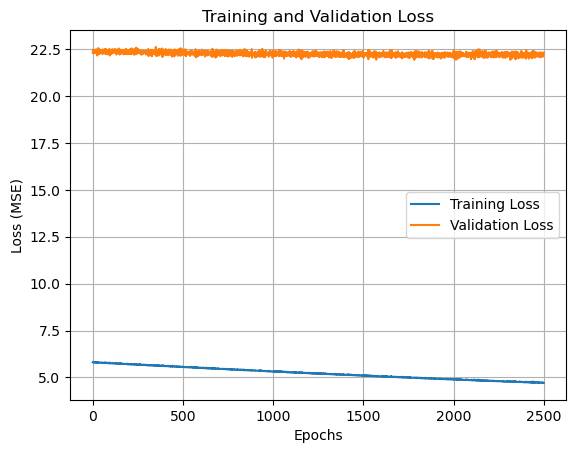

In [17]:
# 训练模型
history = model.fit(F_train, P_train, epochs=2500, validation_data=(F_test, P_test))

# 训练过程的可视化
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


7/7 [==============================] - 0s 2ms/step


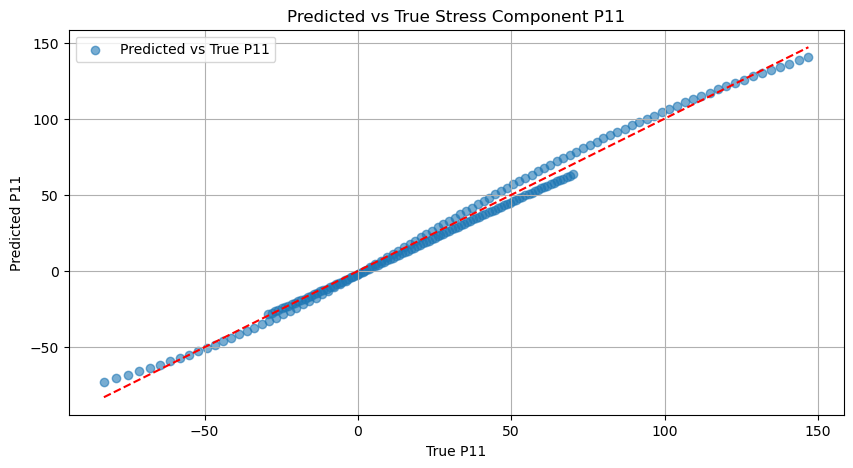

In [18]:
# 预测测试集上的应力分量
P_pred = model.predict(F_test)

# 可视化真实值与预测值的对比
plt.figure(figsize=(10, 5))
plt.scatter(P_test[:, 0], P_pred[:, 0], label="Predicted vs True P11", alpha=0.6)
plt.xlabel("True P11")
plt.ylabel("Predicted P11")
plt.title("Predicted vs True Stress Component P11")
plt.plot([min(P_test[:, 0]), max(P_test[:, 0])], [min(P_test[:, 0]), max(P_test[:, 0])], color='red', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


7/7 [==============================] - 0s 4ms/step


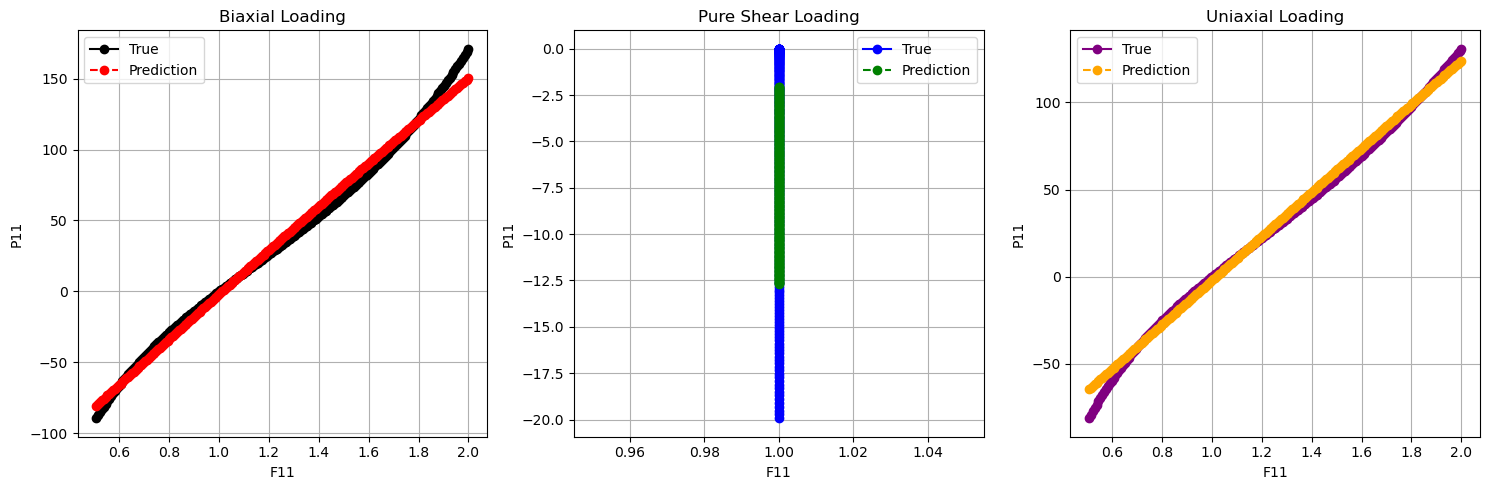

In [ ]:
import matplotlib.pyplot as plt

P_biaxial_pred = model.predict(F_biaxial.reshape(-1, 9))

P_pure_shear_pred = model.predict(F_pure_shear.reshape(-1, 9))
P_uniaxial_pred = model.predict(F_uniaxial.reshape(-1, 9))

def plot_all_stress_vs_deformation(F_biaxial, P_biaxial, P_biaxial_pred, 
                                 F_pure_shear, P_pure_shear, P_pure_shear_pred, 
                                 F_uniaxial, P_uniaxial, P_uniaxial_pred):
    # 提取 F11 和 P11 分量
    F11_biaxial = F_biaxial[:, 0, 0]
    P11_biaxial = P_biaxial[:, 0, 0]
    P11_biaxial_pred = P_biaxial_pred[:, 0]

    F11_pure_shear = F_pure_shear[:, 0, 0]
    P11_pure_shear = P_pure_shear[:, 0, 0]
    P11_pure_shear_pred = P_pure_shear_pred[:, 0]

    F11_uniaxial = F_uniaxial[:, 0, 0]
    P11_uniaxial = P_uniaxial[:, 0, 0]
    P11_uniaxial_pred = P_uniaxial_pred[:, 0]

    # 创建一个包含三个子图的图形
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # 绘制双轴加载
    ax1.plot(F11_biaxial, P11_biaxial, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11_biaxial, P11_biaxial_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("Biaxial Loading")
    ax1.legend()
    ax1.grid(True)

    # 绘制纯剪切加载
    ax2.plot(F11_pure_shear, P11_pure_shear, label="True", marker="o", linestyle="-", color="blue")
    ax2.plot(F11_pure_shear, P11_pure_shear_pred, label="Prediction", marker="o", linestyle="--", color="green")
    ax2.set_xlabel("F11")
    ax2.set_ylabel("P11")
    ax2.set_title("Pure Shear Loading")
    ax2.legend()
    ax2.grid(True)

    # 绘制单轴加载
    ax3.plot(F11_uniaxial, P11_uniaxial, label="True", marker="o", linestyle="-", color="purple")
    ax3.plot(F11_uniaxial, P11_uniaxial_pred, label="Prediction", marker="o", linestyle="--", color="orange")
    ax3.set_xlabel("F11")
    ax3.set_ylabel("P11")
    ax3.set_title("Uniaxial Loading")
    ax3.legend()
    ax3.grid(True)

    # 调整子图之间的间距
    plt.tight_layout()
    plt.show()

# 调用函数绘制三种加载路径的结果
plot_all_stress_vs_deformation(F_biaxial, P_biaxial, P_biaxial_pred, 
                             F_pure_shear, P_pure_shear, P_pure_shear_pred, 
                             F_uniaxial, P_uniaxial, P_uniaxial_pred)
